# Bird Species Classification
----
Using NABirds Dataset and Resnet50 model to classify over 350+ species of birds

### Downloading and Preparing Dataset

In [1]:
path = "data/nabirds/"

In [2]:
import pandas as pd
images = pd.read_csv(path + '/images.txt', sep=" ", header=None, names=['file','path'])
images['cat_num'] = images['path'].str.split('/').str[0]
images.head()

,file,path,cat_num
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0817
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,0860
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,0900
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,0645
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,0929


In [3]:
#import classes to get common_names
classes = pd.read_table(path + '/classes.txt', delimiter=None)
classes.columns = ['code']
classes[['cat_num','common_name']] = classes['code'].str.split(" ", 1, expand=True)
classes = classes.drop(['code'], axis=1)
classes['cat_num'] = classes['cat_num'].str.zfill(4) #fill missing leading zeros
classes.head()

/home/ryan_dsilva_98/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  


,cat_num,common_name
0,0001,"Ducks, Geese, and Swans"
1,0002,"Grouse, Quail, and Allies"
2,0003,Loons
3,0004,Grebes
4,0005,Storks


In [4]:
#merge common_name from classes into images df
images = pd.merge(images, classes,  how='left', on='cat_num')
images.head()

,file,path,cat_num,common_name
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0817,Oak Titmouse
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,0860,Ovenbird
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,0900,Savannah Sparrow
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,0645,Eared Grebe (Nonbreeding/juvenile)
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,0929,Eastern Phoebe


In [5]:
#import train_test_split and merge with images to get the train_test split provided with dataset
split = pd.read_csv(path + '/train_test_split.txt', sep=" ", header=None, names=['file','train_test'])
images = pd.merge(images, split,  how='left', on='file')
images.head()

,file,path,cat_num,common_name,train_test
0,0000139e-21dc-4d0c-bfe1-4cae3c85c829,0817/0000139e21dc4d0cbfe14cae3c85c829.jpg,0817,Oak Titmouse,0
1,0000d9fc-4e02-4c06-a0af-a55cfb16b12b,0860/0000d9fc4e024c06a0afa55cfb16b12b.jpg,0860,Ovenbird,0
2,00019306-9d83-4334-b255-a447742edce3,0900/000193069d834334b255a447742edce3.jpg,0900,Savannah Sparrow,0
3,0001afd4-99a1-4a67-b940-d419413e23b3,0645/0001afd499a14a67b940d419413e23b3.jpg,0645,Eared Grebe (Nonbreeding/juvenile),1
4,000332b8-997c-4540-9647-2f0a8495aecf,0929/000332b8997c454096472f0a8495aecf.jpg,0929,Eastern Phoebe,0


### Deep Learning

In [6]:
from fastai.vision import *
from fastai.metrics import accuracy

In [10]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.1)
data = ImageList.from_df(images, path=path+ '/images', cols='path').split_by_rand_pct().label_from_df(cols='common_name').transform(tfms,size=224).databunch(bs=64)

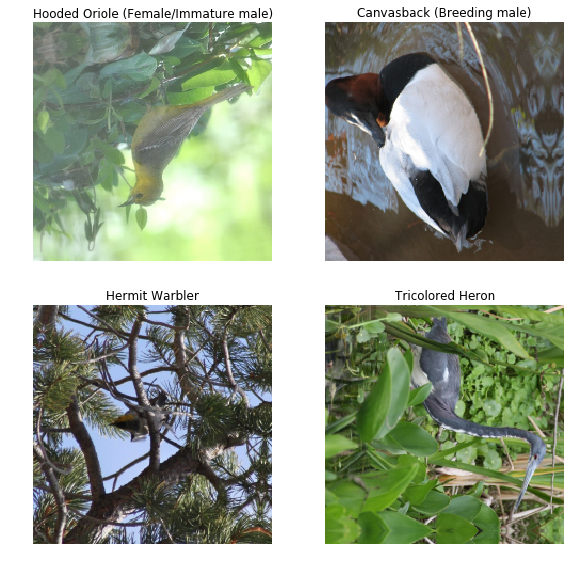

In [11]:
data.show_batch(rows=2)

In [12]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,3.598425,2.677838,0.360070,09:13
1,2.405958,1.708290,0.551689,08:46
2,1.954707,1.397664,0.628192,08:43
3,1.573762,1.210197,0.676071,08:39
4,1.386989,1.169020,0.689147,08:33


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


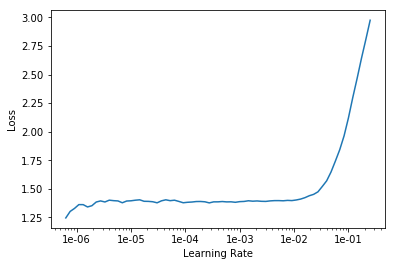

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.save('birdv1')
learn.unfreeze()

### Optimizing and Tuning Parameters

In [15]:
learn.fit_one_cycle(5, slice(1e-7,3e-6))

epoch,train_loss,valid_loss,accuracy,time
0,1.357607,1.164773,0.688736,08:28
1,1.370583,1.159453,0.688427,08:37
2,1.356308,1.150943,0.692751,08:37
3,1.343423,1.149700,0.693266,08:24
4,1.345984,1.146016,0.694296,08:26


In [16]:
learn.save('birdv2')
learn.export('birdwatchin.pkl')

### Performace of the Model

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

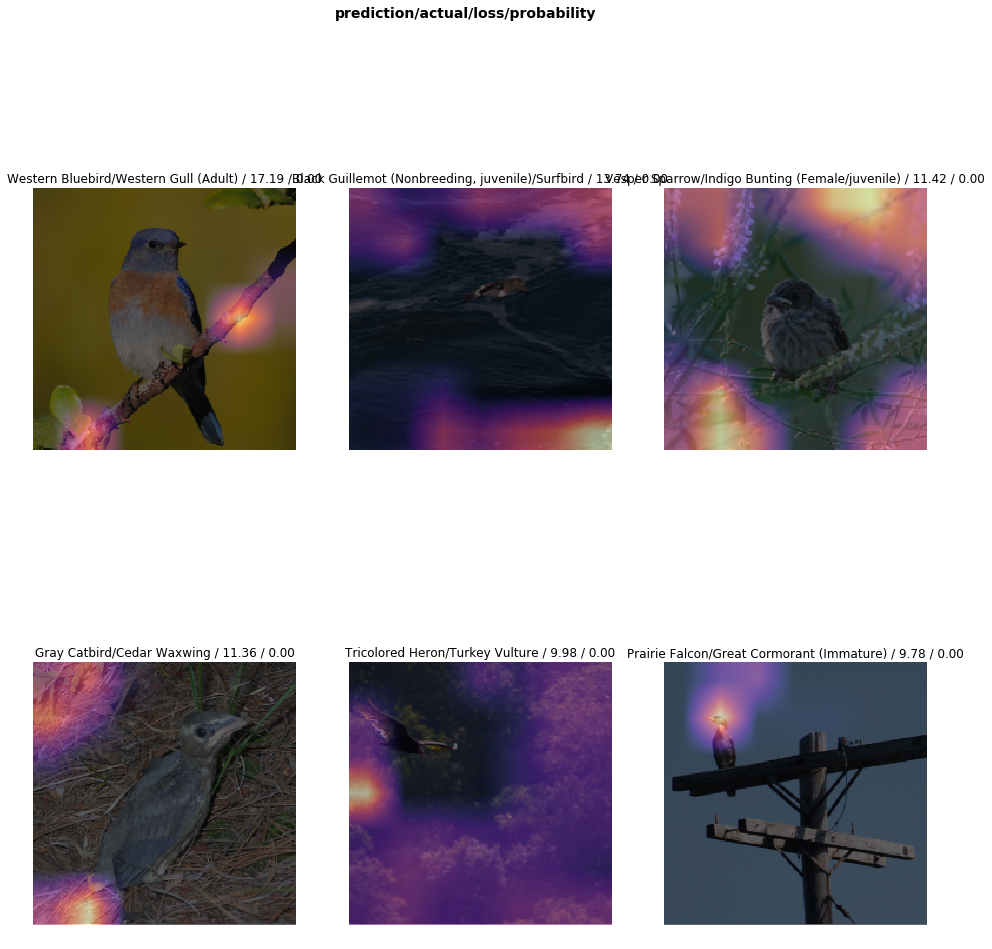

In [18]:
interp.plot_top_losses(6, figsize=(16,16))